In [1]:

import numpy as np
import torch
import torchvision
import torch.nn as nn
import tqdm.notebook as tqdm
import torch.nn.functional as F
import matplotlib.gridspec as gridspec

from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms.functional import pil_to_tensor
from torchvision.transforms import ToTensor, Normalize, Resize
from torchvision import transforms
from torchvision.transforms import functional as TF
import numpy as np



In [2]:
#@title Function for rescaling and displaying images.
#@markdown This function is taken from the TorchRay library (https://github.com/facebookresearch/TorchRay).

def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
    if isinstance(img, Image.Image):
        img = pil_to_tensor(img)
    handle = None
    with torch.no_grad():
        if not lim:
            lim = [img.min(), img.max()]
        img = img - lim[0]  # also makes a copy
        img.mul_(1 / (lim[1] - lim[0]))
        img = torch.clamp(img, min=0, max=1)
        if not quiet:
            bitmap = img.expand(3,
                                *img.shape[1:]).permute(1, 2, 0).cpu().numpy()
    return bitmap

In [3]:
#@title Functions from utilities folder in RELAX repository
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def imagenet_image_transforms(device: str, new_shape_of_image: int = 224):
    """
    Returns transformations that takes a torch tensor and transforms it into a new tensor
    of size (1, C, new_shape_of_image, new_shape_of_image), normalizes the image according
    to the statistics from the Imagenet dataset, and puts the tensor on the desired device.
    """
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((new_shape_of_image, new_shape_of_image)),
        torchvision.transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        torchvision.transforms.Lambda(unsqeeze_image),
        ToDevice(device),
    ])

    return transform

class ToDevice(torch.nn.Module):
    """
    Sends the input object to the device specified in the
    object's constructor by calling .to(device) on the object.
    """
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, img):
        return img.to(self.device)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(device={self.device})"

def unsqeeze_image(input_image: torch.Tensor) -> torch.Tensor:
    return input_image.unsqueeze(0)

In [4]:
#@title Functions from masking functions folder in RELAX repository
#@markdown This function implements the generator for creating masks in our framework.
#@markdown The implementation is based on the TorchRay implementation and the
#@markdown RISE implementation at: https://github.com/eclique/RISE.

def mask_generator(
    batch_size: int,
    shape: tuple,
    device: str,
    num_cells: int = 7,
    probablity_of_drop: float = 0.5,
    num_spatial_dims: int = 2) -> torch.Tensor:
    """
    Generates a batch of masks by sampling Bernoulli random variables (probablity_of_drop) in a lower dimensional grid (num_cells)
    and upsamples the discrete masks using bilinear interpolation to obtain smooth continious mask in (0, 1).
    """

    pad_size = (num_cells // 2, num_cells // 2, num_cells // 2, num_cells // 2)

    grid = (torch.rand(batch_size, 1, *((num_cells,) * num_spatial_dims), device=device) < probablity_of_drop).float()
    grid_up = F.interpolate(grid, size=(shape), mode='bilinear', align_corners=False)
    grid_up = F.pad(grid_up, pad_size, mode='reflect')

    shift_x = torch.randint(0, num_cells, (batch_size,), device=device)
    shift_y = torch.randint(0, num_cells, (batch_size,), device=device)

    masks = torch.empty((batch_size, 1, shape[0], shape[1]), device=device)

    for mask_i in range(batch_size):
        masks[mask_i] = grid_up[
            mask_i,
            :,
            shift_x[mask_i]:shift_x[mask_i] + shape[0],
            shift_y[mask_i]:shift_y[mask_i] + shape[1]
        ]

    yield masks

In [5]:
#@title Class that implements the RELAX framework
from tqdm import tqdm

class RELAX(nn.Module):
    """
    Class for RELAX, a framework for explaining representations of data through masking and latent space similairty
    measurments.

    Link to ArXiv paper: https://arxiv.org/abs/2112.10161
    Link to International Journal of Computer Vision version: https://link.springer.com/article/10.1007/s11263-023-01773-2

    Parameters
    ----------
    input_image
        Input image to be explained.
    encoder
        Encoder that transforms the input image into a new representation
    batch_size
        The size of each batch of masks
    num_batches
        Number of batches with masks to generate
    similarity_measure
        Function for measuring similarity between masked and unmasked representation
    sum_of_weights_initial_value
        Initial values for running mean and variance estimator to avoid division by zero
    """
    def __init__(self,
                 input_image: torch.Tensor,
                 encoder: nn.Module,
                 batch_size: int = 100,
                 num_batches: int = 30,
                 similarity_measure: nn.Module = nn.CosineSimilarity(dim=1),
                 sum_of_weights_initial_value: float = 1e-10):

        super().__init__()

        self.batch_size = batch_size
        self.input_image = input_image
        self.num_batches = num_batches
        self.device = input_image.device
        self.encoder = encoder.to(self.device)
        self.similarity_measure = similarity_measure
        self.shape = tuple(input_image.shape[2:])
        self.unmasked_representations = encoder(self.input_image).expand(batch_size, -1)

        self.importance = torch.zeros(self.shape, device=self.device)
        self.uncertainty = torch.zeros(self.shape, device=self.device)

        self.sum_of_weights = sum_of_weights_initial_value*torch.ones(self.shape, device=self.device)

    def forward(self, **kwargs) -> None:
        
        for _ in range(self.num_batches):
            idx = 1
            for masks in  mask_generator(self.batch_size, self.shape, self.device, **kwargs):
                # print('Completed Masks ', idx, 'out of ', self.batch_size)
                idx += 1
                x_mask = self.input_image * masks
                # Print masked image
                # plt.imshow(imsc(x_mask.squeeze()))

                # print(x_mask.shape)

                masked_representations = self.encoder(x_mask)
                # print('Representation obtained')

                similarity_scores = self.similarity_measure(
                    self.unmasked_representations,
                    masked_representations
                )

                # print('Similarity scores obtained')

                for similarity_i, mask_i in zip(similarity_scores, masks.squeeze()):

                    self.sum_of_weights += mask_i

                    importance_previous_step = self.importance.clone()
                    self.importance += mask_i * (similarity_i - self.importance) / self.sum_of_weights
                    self.uncertainty += (similarity_i - self.importance) * (similarity_i - importance_previous_step) * mask_i

        return None

    @property
    def u_relax(self) -> torch.Tensor:
        return self.importance * (self.uncertainty <= self.uncertainty.median())

In [6]:
import torch.nn as nn
import torchvision.models as models

class BaseSimCLRException(Exception):
    """Base exception"""


class InvalidBackboneError(BaseSimCLRException):
    """Raised when the choice of backbone Convnet is invalid."""


class InvalidDatasetSelection(BaseSimCLRException):
    """Raised when the choice of dataset is invalid."""



class ResNetSimCLR(nn.Module):

    def __init__(self, base_model, out_dim):
        super(ResNetSimCLR, self).__init__()
        self.resnet_dict = {"resnet18": models.resnet18(pretrained=False, num_classes=out_dim),
                            "resnet50": models.resnet50(pretrained=False, num_classes=out_dim)}

        self.backbone = self._get_basemodel(base_model)
        dim_mlp = self.backbone.fc.in_features

        # add mlp projection head
        self.backbone.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.backbone.fc)

    def _get_basemodel(self, model_name):
        try:
            model = self.resnet_dict[model_name]
        except KeyError:
            raise InvalidBackboneError(
                "Invalid backbone architecture. Check the config file and pass one of: resnet18 or resnet50")
        else:
            return model

    def forward(self, x):
        return self.backbone(x)

In [7]:
# Define constants
BATCH_SIZE = 128
NUM_WORKERS = 0
NUM_CLASSES = 10
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

def load_simclr(model_path='../../src/SimCLR/runs/Mar25_11-51-42_node3/checkpoint_1000.pth.tar', base_model='resnet18'):
    model = ResNetSimCLR(base_model=base_model, out_dim=128)
    model.load_state_dict(torch.load(model_path, map_location='cuda')['state_dict'])
    encoder = nn.Sequential(model.backbone)
    encoder.eval()
    return encoder

# # Load the pre-trained model
# model = load_simclr(model_path='/kaggle/input/simclr-1000-checkpoint/other/default/1/checkpoint_1000.pth.tar').to('cuda')

100%|██████████| 170M/170M [00:03<00:00, 49.3MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
# import kagglehub
# _ = kagglehub.model_download('strawhat56/simclr-1000-checkpoint/Other/default/1')

In [8]:
model = torch.hub.load('facebookresearch/swav:main', 'resnet50')

Downloading: "https://github.com/facebookresearch/swav/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://dl.fbaipublicfiles.com/deepcluster/swav_800ep_pretrain.pth.tar" to /root/.cache/torch/hub/checkpoints/swav_800ep_pretrain.pth.tar
100%|██████████| 108M/108M [00:00<00:00, 228MB/s]  


In [9]:
! wget 'https://upload.wikimedia.org/wikipedia/commons/d/de/Nokota_Horses_cropped.jpg'
! wget 'https://upload.wikimedia.org/wikipedia/commons/3/36/United_Airlines_Boeing_777-200_Meulemans.jpg'
! wget 'https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Atelopus_zeteki1.jpg/1920px-Atelopus_zeteki1.jpg'
! wget 'https://upload.wikimedia.org/wikipedia/commons/3/30/Containerterminal_Altenwerder_%28Hamburg-Altenwerder%29.Iris_Bolten.4.phb.ajb.jpg'
! wget 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Black_Labrador_Retriever_-_Male_IMG_3323.jpg/1280px-Black_Labrador_Retriever_-_Male_IMG_3323.jpg'
! wget 'https://upload.wikimedia.org/wikipedia/commons/thumb/3/36/Bottle%2C_Ding_ware%2C_Hebei_province%2C_China%2C_Northern_Song_dynasty%2C_11th-early_12th_century_AD%2C_porcelain_with_iron_pigment_under_transparent_ivory-toned_glaze_-_Freer_Gallery_of_Art_-_DSC05557.JPG/800px-thumbnail.jpg'
! wget 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/Zoo_de_Vincennes%2C_Paris%2C_France_April_2014_%287%29%2C_crop.jpg/800px-Zoo_de_Vincennes%2C_Paris%2C_France_April_2014_%287%29%2C_crop.jpg'
! wget 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Bun_thit_nuong.jpg/1024px-Bun_thit_nuong.jpg'
! wget 'https://upload.wikimedia.org/wikipedia/commons/thumb/1/1d/Taj_Mahal_%28Edited%29.jpeg/1920px-Taj_Mahal_%28Edited%29.jpeg'
! wget 'https://upload.wikimedia.org/wikipedia/commons/thumb/a/a9/Dolphin_Encounter-9563.jpg/1280px-Dolphin_Encounter-9563.jpg'
! wget 'https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/Tringa_totanus-pjt.jpg/640px-Tringa_totanus-pjt.jpg'

--2025-04-30 16:24:04--  https://upload.wikimedia.org/wikipedia/commons/d/de/Nokota_Horses_cropped.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78356 (77K) [image/jpeg]
Saving to: ‘Nokota_Horses_cropped.jpg’

Nokota_Horses_cropp 100%[===================>]  76.52K  --.-KB/s    in 0.06s   

2025-04-30 16:24:04 (1.32 MB/s) - ‘Nokota_Horses_cropped.jpg’ saved [78356/78356]

--2025-04-30 16:24:04--  https://upload.wikimedia.org/wikipedia/commons/3/36/United_Airlines_Boeing_777-200_Meulemans.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243970 (238K) [image/jpeg]
Saving to: ‘United_Airlines_Boeing_777-20

In [15]:
def perform_augmentation_experiment(model, idx=0):
    # Load 10 images from the CIFAR-10 dataset
    import torch
    import torchvision
    import torchvision.transforms as transforms
    from torchvision.transforms.functional import rotate
    
    images = []
    
    image_files = ['./640px-Tringa_totanus-pjt.jpg','./1280px-Black_Labrador_Retriever_-_Male_IMG_3323.jpg','./Containerterminal_Altenwerder_(Hamburg-Altenwerder).Iris_Bolten.4.phb.ajb.jpg', './Nokota_Horses_cropped.jpg', './United_Airlines_Boeing_777-200_Meulemans.jpg']
    
    for image_filename in image_files:
        img = pil_to_tensor(Image.open(image_filename)).float()
        img = imagenet_image_transforms(device='cuda', new_shape_of_image=224)(img)
        images.append(img)
    
    image = images[idx]
    
    # Check if the final trained model's representations are still invariant to the augmentations used during training
    relax = RELAX(image, model).to('cuda')
    
    with torch.no_grad(): 
        relax.forward()
    importance_map_original = relax.importance.numpy(force=True)
    
    # Display the original image, importance map, and uncertainty map
    fig = plt.figure(figsize=(14, 4))
    ax1 = fig.add_subplot(1, 3, 1)
    im1 = ax1.imshow(imsc(image[0]))
    ax1.axis('off')
    ax1.set_title('input image')
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.imshow(imsc(image[0]))
    im2 = plt.imshow(relax.importance.numpy(force=True), alpha=0.75, cmap='bwr')
    ax2.axis('off')
    ax2.set_title('importance')
    plt.colorbar(im2, fraction=0.046, pad=0.04)
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.imshow(imsc(image[0]))
    im3 = plt.imshow(relax.uncertainty.numpy(force=True), alpha=0.75, cmap='bwr')
    ax3.axis('off')
    ax3.set_title('uncertainty')
    plt.colorbar(im3, fraction=0.046, pad=0.04)
    plt.show()
    from torchvision.transforms import functional as TF
    import numpy as np
    
    # Define deterministic augmentations with manual control
    def apply_transform(image, idx):
        if idx == 0:
            return TF.hflip(image), 'hflip'
        elif idx == 1:
            return TF.vflip(image), 'vflip'
        elif idx == 2:
            return TF.rotate(image, angle=15, fill=0), 'rotate_15'
        elif idx == 3:
            return TF.rgb_to_grayscale(image, num_output_channels=3), 'grayscale'  # can't invert
        return image, None
    
    # Apply deterministic augmentations and record their type
    augmented_images = []
    applied_transforms = []
    
    num_transforms = 4
    for i in range(num_transforms):
        img_aug, transform_name = apply_transform(image, i)
        augmented_images.append(img_aug)
        applied_transforms.append(transform_name)
    
    # Run RELAX on the augmented images
    augmented_importance_maps = []
    for i in range(len(augmented_images)):
        relax = RELAX(augmented_images[i].to('cuda'), model).to('cuda')
        with torch.no_grad(): relax.forward()
    
        imp_map = relax.importance.numpy(force=True)
        augmented_importance_maps.append(imp_map)
    
        fig = plt.figure(figsize=(14, 4))
        ax1 = fig.add_subplot(1, 3, 1)
        im1 = ax1.imshow(imsc(augmented_images[i][0]))
        ax1.axis('off')
        ax1.set_title('input image')
    
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.imshow(imsc(augmented_images[i][0]))
        im2 = plt.imshow(imp_map, alpha=0.75, cmap='bwr')
        ax2.axis('off')
        ax2.set_title('importance')
        plt.colorbar(im2, fraction=0.046, pad=0.04)
    
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.imshow(imsc(augmented_images[i][0]))
        im3 = plt.imshow(relax.uncertainty.numpy(force=True), alpha=0.75, cmap='bwr')
        ax3.axis('off')
        ax3.set_title('uncertainty')
        plt.colorbar(im3, fraction=0.046, pad=0.04)
        plt.show()
    return importance_map_original, augmented_importance_maps, applied_transforms

In [16]:
from torchvision.transforms import functional as TF
import numpy as np

def calculate_iou(importance_map_original, augmented_importance_maps, applied_transforms):
    # create original mask
    average_importance = np.mean(importance_map_original)
    mask = np.where(importance_map_original > average_importance, 1, 0)
    
    # create augmented masks
    augmented_masks = []
    for i in range(4):
        threshold = np.mean(augmented_importance_maps[i])
        augmented_mask = np.where(augmented_importance_maps[i] > threshold, 1, 0)
        augmented_masks.append(augmented_mask)
    
    # Apply inverse transform on mask
    def inverse_transform(mask, transform_name):
        mask = torch.tensor(mask, dtype=torch.float32)
        if transform_name == 'hflip':
            return TF.hflip(mask)
        elif transform_name == 'vflip':
            return TF.vflip(mask)
        elif transform_name == 'rotate_15':
            mask = mask.unsqueeze(0)
            mask = TF.rotate(mask, angle=-15, fill=0)
            return mask[0]
        else:
            return mask  # non-invertible transforms skipped
        return mask
    
    # Now apply inverse transforms and compute IOU
    ious = []
    original_mask_tensor = torch.tensor(mask, dtype=torch.float32)
    
    for i in range(len(augmented_masks)):
        inv_mask = inverse_transform(augmented_masks[i], applied_transforms[i])
        inv_mask = inv_mask.numpy()
        union = np.logical_or(inv_mask, mask).sum()
        intersection = np.logical_and(inv_mask, mask).sum()
        iou = intersection / union if union > 0 else 0
        ious.append(iou)
    
        print(f"Transform: {applied_transforms[i]}, IOU: {iou:.4f}")



## SwAV

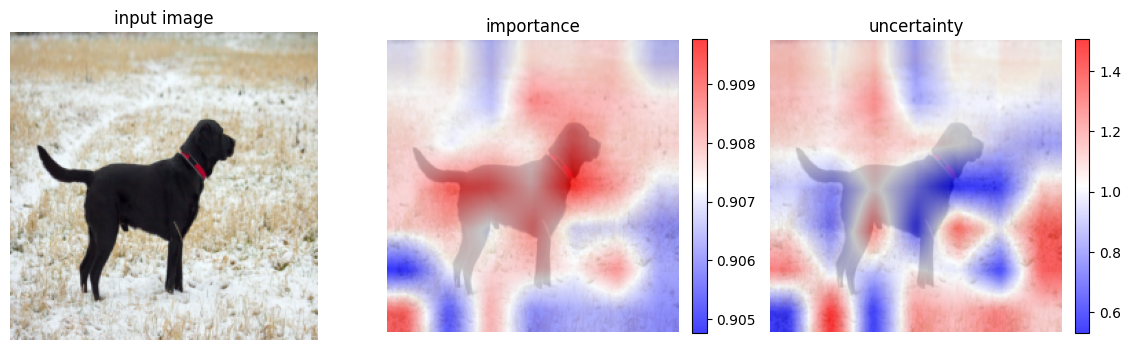

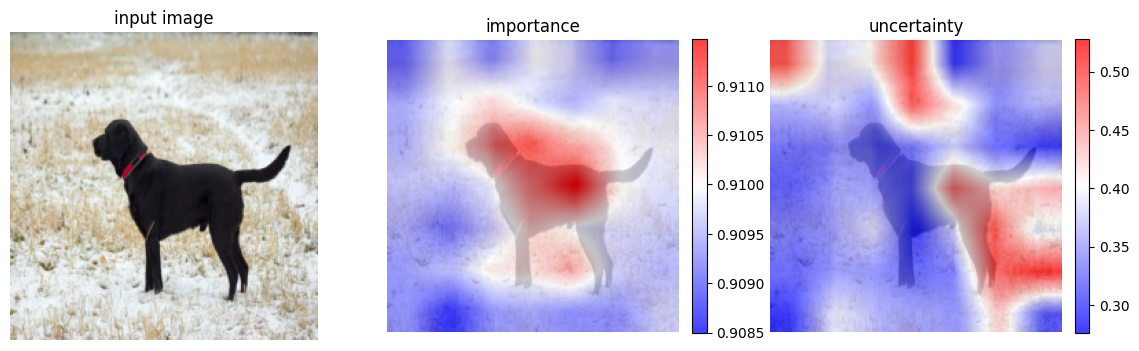

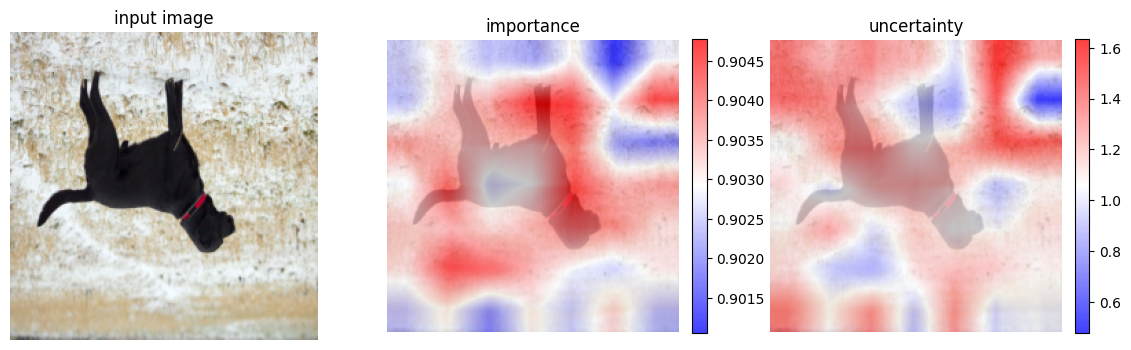

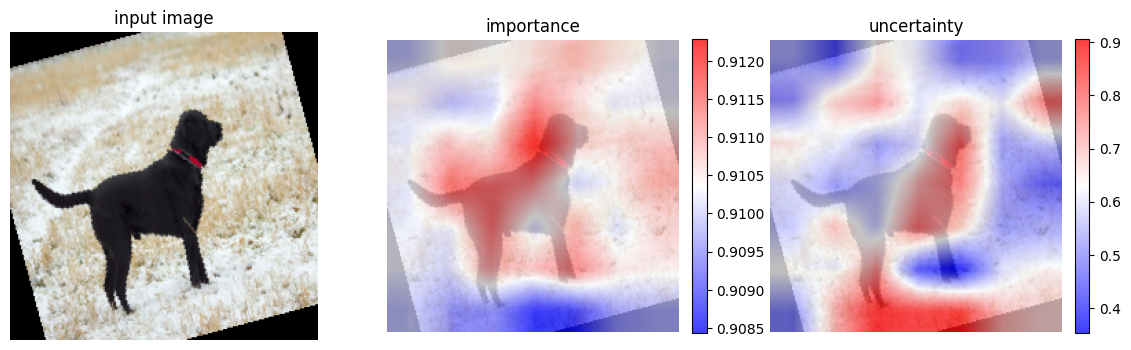

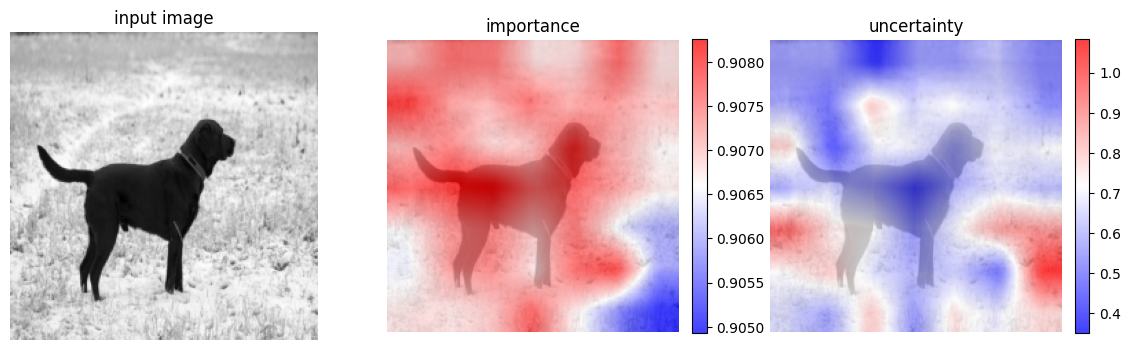

In [17]:
importance_map_original, augmented_importance_maps, applied_transforms = perform_augmentation_experiment(model,1)


In [18]:
calculate_iou(importance_map_original, augmented_importance_maps, applied_transforms)

Transform: hflip, IOU: 0.5721
Transform: vflip, IOU: 0.4508
Transform: rotate_15, IOU: 0.4860
Transform: grayscale, IOU: 0.5229


## MoCo

In [19]:
import torch
import torch.nn as nn
# import moco.builder as builder
# import moco.loader as loader
import torchvision.models as models
from PIL import Image
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

In [20]:
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
# # run this on first run
# ! mkdir checkpoint
# ! wget https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v2_800ep/moco_v2_800ep_pretrain.pth.tar -P checkpoint
# ! wget https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v1_200ep/moco_v1_200ep_pretrain.pth.tar -P checkpoint

--2025-04-30 16:29:41--  https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v2_800ep/moco_v2_800ep_pretrain.pth.tar
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.14, 3.163.189.96, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112133139 (107M) [application/octet-stream]
Saving to: ‘checkpoint/moco_v2_800ep_pretrain.pth.tar’

moco_v2_800ep_pretr 100%[===================>] 106.94M   192MB/s    in 0.6s    

2025-04-30 16:29:42 (192 MB/s) - ‘checkpoint/moco_v2_800ep_pretrain.pth.tar’ saved [112133139/112133139]

--2025-04-30 16:29:42--  https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v1_200ep/moco_v1_200ep_pretrain.pth.tar
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.108, 3.163.189.96, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.14|:443... connected.
HTTP re

In [24]:

model = models.__dict__['resnet50']()
model.fc = nn.Identity()

chpkt = torch.load("/kaggle/working/checkpoint/moco_v2_800ep_pretrain.pth.tar")

state_dict = chpkt['state_dict']
for k in list(state_dict.keys()):
    if k.startswith("module.encoder_q") and not k.startswith("module.encoder_q.fc"):
        # remove prefix
        state_dict[k[len("module.encoder_q.") :]] = state_dict[k]
    # delete renamed or unused k
    del state_dict[k]
msg = model.load_state_dict(state_dict, strict=False)
model = model.to(device)
model.eval()
print("Model loaded successfully.")
print(model)

Model loaded successfully.
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kern

/tmp/ipykernel_31/2849098489.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chpkt = torch.load("/kaggle/working/checkpoint/moco_v2_800ep_pretrain.pth.tar")


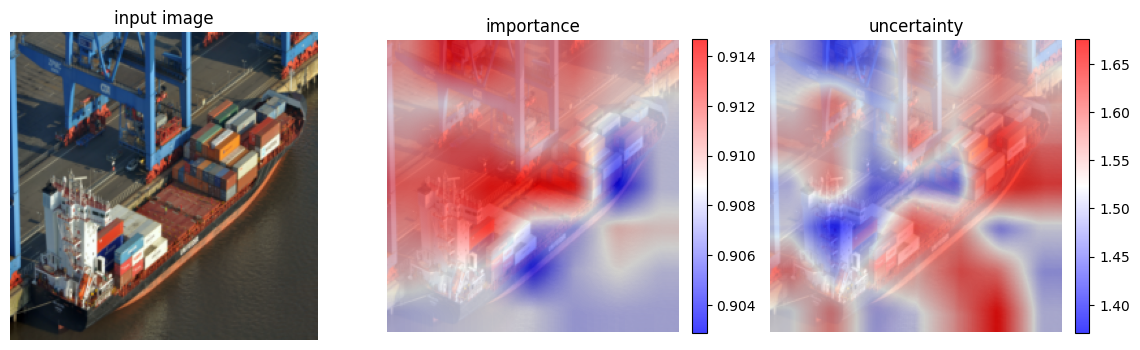

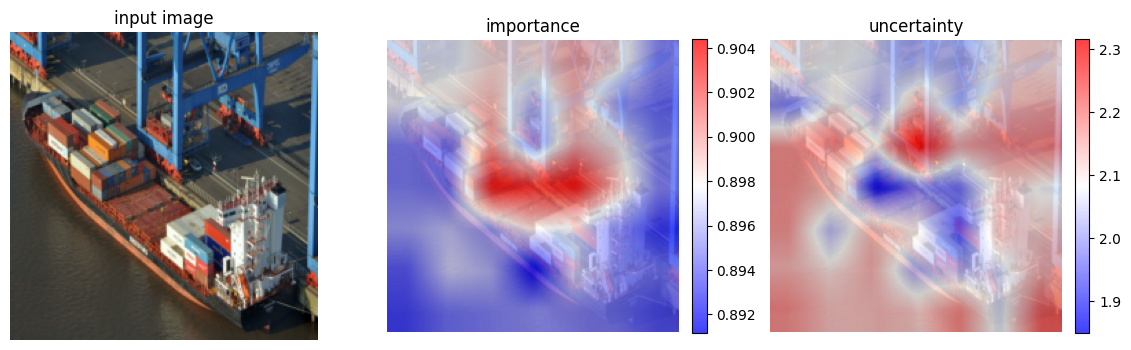

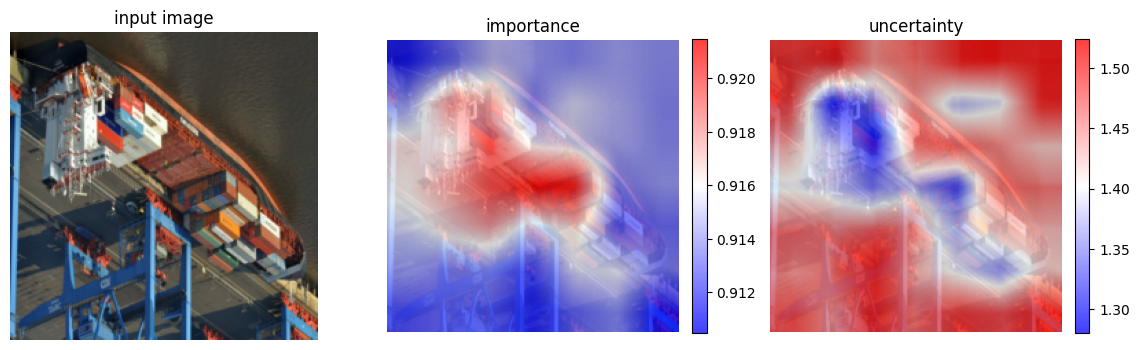

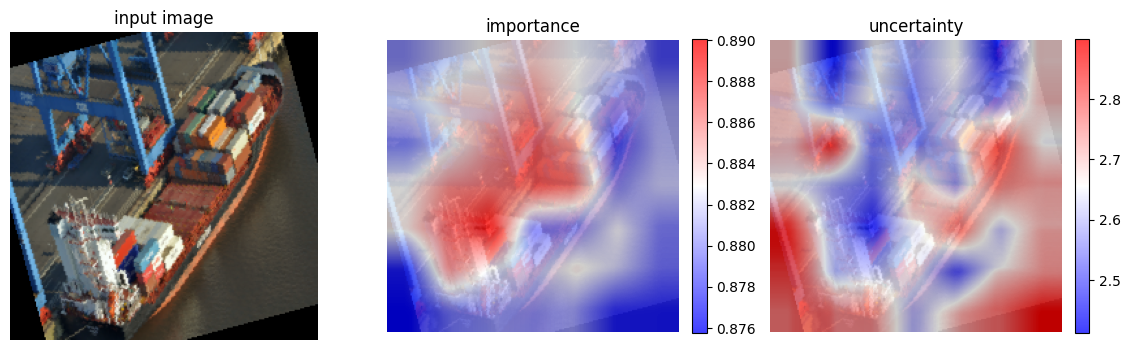

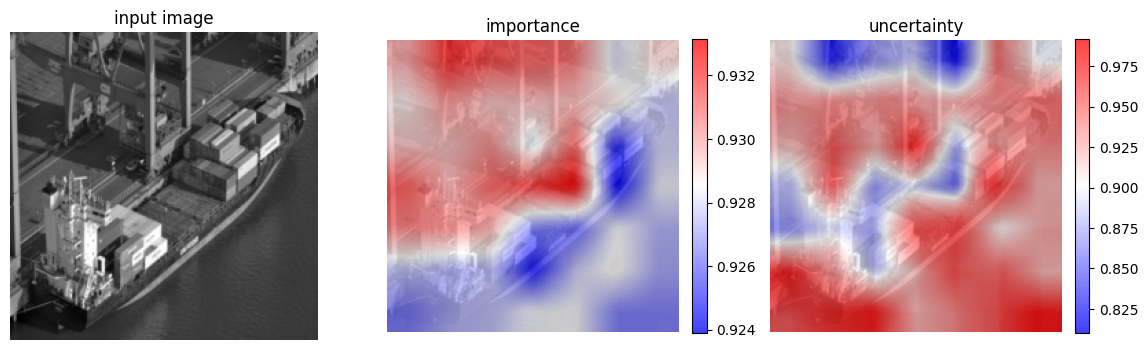

In [26]:
importance_map_original, augmented_importance_maps, applied_transforms = perform_augmentation_experiment(model,2)

In [27]:
calculate_iou(importance_map_original, augmented_importance_maps, applied_transforms)

Transform: hflip, IOU: 0.6053
Transform: vflip, IOU: 0.4519
Transform: rotate_15, IOU: 0.6990
Transform: grayscale, IOU: 0.8944


In [ ]:
# importance_map_original, augmented_importance_maps, applied_transforms = perform_augmentation_experiment(model,1)
# calculate_iou(importance_map_original, augmented_importance_maps, applied_transforms)

## Trained From Scratch simCLR (On cifar10)

In [28]:
import kagglehub
_ = kagglehub.model_download('strawhat56/simclr-1000-checkpoint/Other/default/1')

In [29]:
model = load_simclr(model_path='/kaggle/input/simclr-1000-checkpoint/other/default/1/checkpoint_1000.pth.tar')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_31/2195429812.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

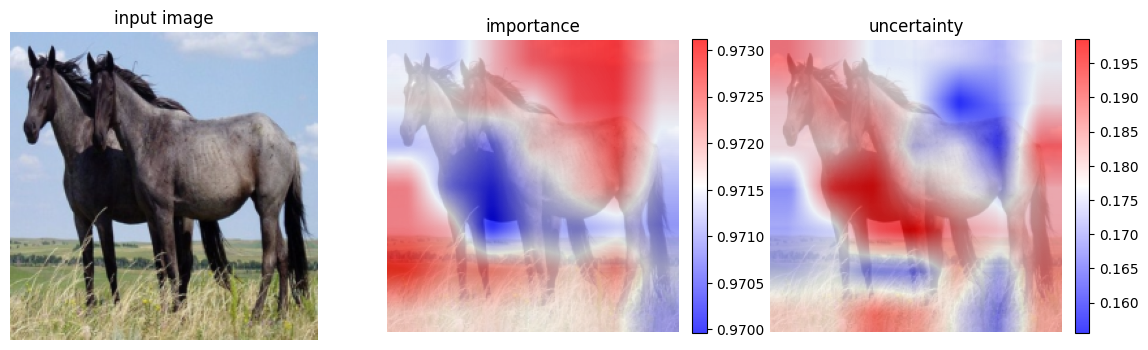

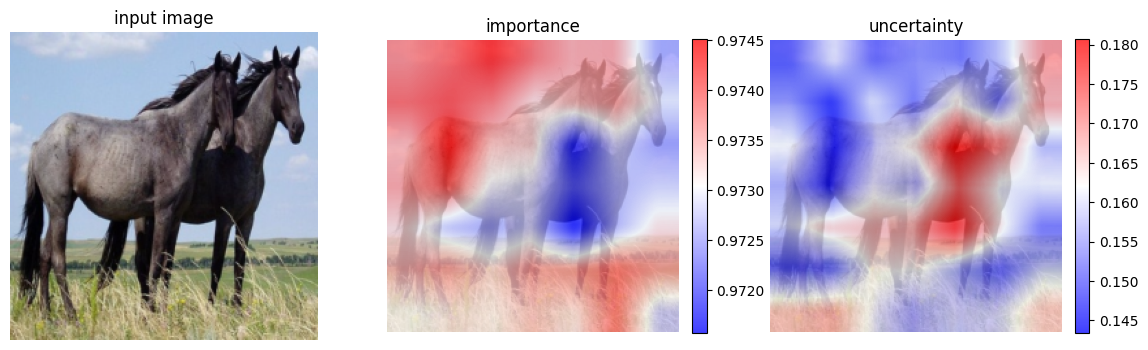

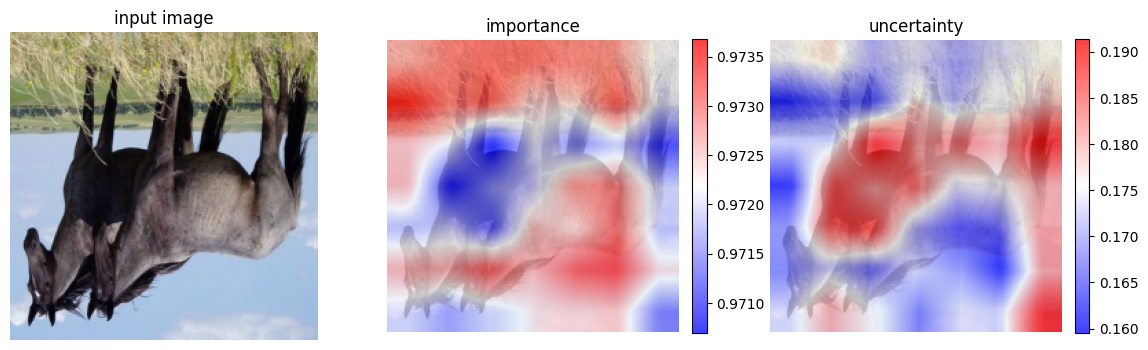

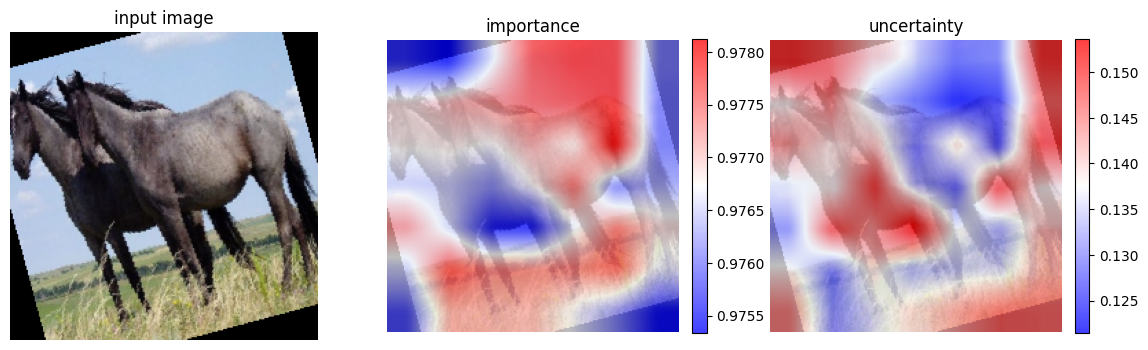

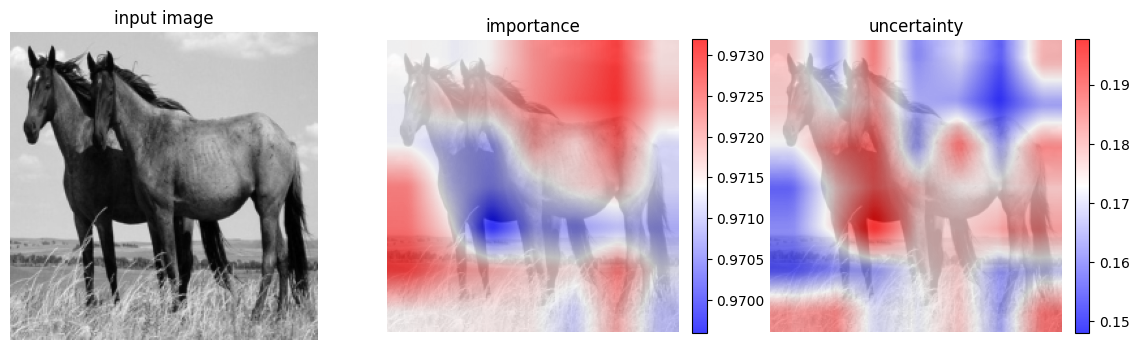

Transform: hflip, IOU: 0.6228
Transform: vflip, IOU: 0.6415
Transform: rotate_15, IOU: 0.6183
Transform: grayscale, IOU: 0.7654


In [31]:
importance_map_original, augmented_importance_maps, applied_transforms = perform_augmentation_experiment(model,3)
calculate_iou(importance_map_original, augmented_importance_maps, applied_transforms)

In [ ]:
! wget 'https://storage.cloud.google.com/simclr-gcs/checkpoints/ResNet50_2x.zip'

In [ ]:
model = load_simclr(model_path='/kaggle/working/ResNet50_2x.zip', base_model='resnet50')